In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

**Read files and process data**

In [2]:
case_path = '../../data/cases/'
ca_cases = pd.read_csv(case_path + 'CA_JHU_cases.csv')
fl_cases = pd.read_csv(case_path + 'FL_JHU_cases.csv')
ga_cases = pd.read_csv(case_path + 'GA_JHU_cases.csv')
ny_cases = pd.read_csv(case_path + 'NY_JHU_cases.csv')

In [3]:
cases = {'California': ca_cases, 
         'Florida': fl_cases, 
         'Georgia': ga_cases, 
         'NewYork': ny_cases}

In [4]:
def preprocess(df, state):
    #Set date to datetime obj
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    #start from rows where we have COVID Cases (?)
    df = df[df[state + '.JHU_ConfirmedCases.data'] > 0]
    #Given time constraints, just focus on confirmed cases
    ret_cols = ['date', state + '.JHU_ConfirmedCases.data']
    return df[ret_cols]

In [5]:
def get_new_cases(df):
    # Return df showing only new cases on each date
    case_count = []
    last_count = 0

    for ind, dt, cs in df.itertuples():
        case_count.append(cs-last_count)
        last_count = cs
    
    df['new_cases'] = pd.Series(case_count)
    
    ret_cols = ['date', 'new_cases']
    return df[ret_cols]

In [6]:
for state, df in cases.items():
    cases[state] = get_new_cases(preprocess(df, state).reset_index(drop=True))
    print('{0}: {1} days available'.format(state, len(cases[state])))

California: 290 days available
Florida: 254 days available
Georgia: 259 days available
NewYork: 254 days available


**Write consolidated new case data**

In [7]:
all_df = pd.DataFrame(columns=['state','date','new_cases'])

for key, val in cases.items():
    df = val.copy()
    df['state'] = key
    all_df = all_df.append(df[['state','date','new_cases']])

# Uncomment line below to write data into csv
# all_df.to_csv(r'case_count.csv', index = False)

# **ARIMA Tests**

In [8]:
def find_best_param(df_train, p_list, d_list, q_list):
    import warnings
    warnings.filterwarnings('ignore')

    p_best = 0
    d_best = 0
    q_best = 0
    rmse_best = np.inf
    
    for p in p_list:
        for d in d_list:
            for q in q_list:
                try:
                    model = ARIMA(df_train['new_cases'], order=(p, d, q))
                    model_fit = model.fit()
                    rmse = np.sqrt(sum((df_train['new_cases']-model_fit.fittedvalues)**2))

                    if rmse < rmse_best:
                        p_best = p
                        d_best = d
                        q_best = q
                        rmse_best = rmse
                except:
                    continue
    
    return p_best, d_best, q_best

In [9]:
p_list = list(range(6))
d_list = list(range(6))
q_list = list(range(6))

In [10]:
train_split = 0.9

**California**

In [11]:
ca_casecount = cases['California']

In [12]:
# Split the data set
ca_train = ca_casecount[:int(train_split*(len(ca_casecount)))]
ca_test = ca_casecount[int(train_split*(len(ca_casecount))):]

In [13]:
p_ca, d_ca, q_ca = find_best_param(ca_train, p_list, d_list, q_list)
print(p_ca, d_ca, q_ca)

5 1 5


In [14]:
ca_model = ARIMA(ca_train['new_cases'], order=(p_ca, d_ca, q_ca))

In [15]:
ca_fit = ca_model.fit()

Train RMSE: 49202.09


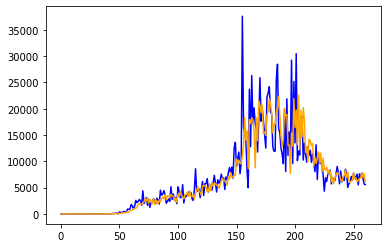

In [16]:
# Check fit on training data
plt.plot(ca_train['new_cases'], 'blue')
plt.plot(ca_fit.fittedvalues, 'orange')

ca_train_rmse = round(np.sqrt(sum((ca_train['new_cases']-ca_fit.fittedvalues)**2)),2)
print(f'Train RMSE: {ca_train_rmse}')

In [17]:
# Predict future cases
ca_pred = ca_fit.predict(start=int(train_split*(len(ca_casecount))), end=len(ca_casecount)-1)

Test RMSE: 21659.18


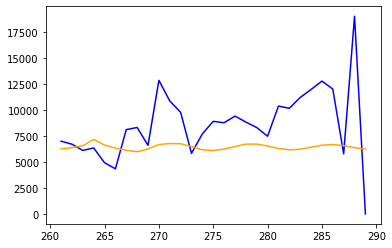

In [18]:
# Check quality of predictions
plt.plot(ca_test['new_cases'], 'blue')
plt.plot(ca_pred, 'orange')

ca_test_rmse = round(np.sqrt(sum((ca_test['new_cases']-ca_pred)**2)),2)
print(f'Test RMSE: {ca_test_rmse}')

**Florida**

In [19]:
fl_casecount = cases['Florida']

In [20]:
# Split the data set
fl_train = fl_casecount[:int(train_split*(len(fl_casecount)))]
fl_test = fl_casecount[int(train_split*(len(fl_casecount))):]

In [21]:
p_fl, d_fl, q_fl = find_best_param(fl_train, p_list, d_list, q_list)
print(p_fl, d_fl, q_fl)

5 1 3


In [22]:
fl_model = ARIMA(fl_train['new_cases'], order=(p_fl, d_fl, q_fl))

In [23]:
fl_fit = fl_model.fit()

Train RMSE: 47844.89


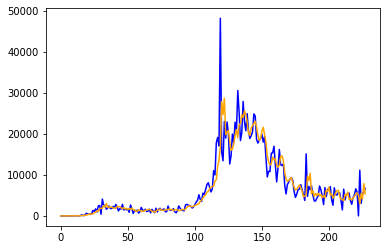

In [24]:
# Check fit on training data
plt.plot(fl_train['new_cases'], 'blue')
plt.plot(fl_fit.fittedvalues, 'orange')

fl_train_rmse = round(np.sqrt(sum((fl_train['new_cases']-fl_fit.fittedvalues)**2)),2)
print(f'Train RMSE: {fl_train_rmse}')

In [25]:
# Predict future cases
fl_pred = fl_fit.predict(start=int(train_split*(len(fl_casecount))), end=len(fl_casecount)-1)

Test RMSE: 20175.36


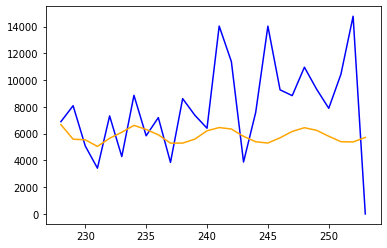

In [26]:
# Check quality of predictions
plt.plot(fl_test['new_cases'], 'blue')
plt.plot(fl_pred, 'orange')

fl_test_rmse = round(np.sqrt(sum((fl_test['new_cases']-fl_pred)**2)),2)
print(f'Test RMSE: {fl_test_rmse}')

**Georgia**

In [27]:
ga_casecount = cases['Georgia']

In [28]:
# Split the data set
ga_train = ga_casecount[:int(train_split*(len(ga_casecount)))]
ga_test = ga_casecount[int(train_split*(len(ga_casecount))):]

In [29]:
p_ga, d_ga, q_ga = find_best_param(ga_train, p_list, d_list, q_list)
print(p_ga, d_ga, q_ga)

5 2 5


In [30]:
ga_model = ARIMA(ga_train['new_cases'], order=(p_ga, d_ga, q_ga))

In [31]:
ga_fit = ga_model.fit()

Train RMSE: 16507.18


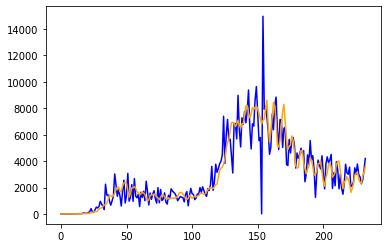

In [32]:
# Check fit on training data
plt.plot(ga_train['new_cases'], 'blue')
plt.plot(ga_fit.fittedvalues, 'orange')

ga_train_rmse = round(np.sqrt(sum((ga_train['new_cases']-ga_fit.fittedvalues)**2)),2)
print(f'Train RMSE: {ga_train_rmse}')

In [33]:
# Predict future cases
ga_pred = ga_fit.predict(start=int(train_split*(len(ga_casecount))), end=len(ga_casecount)-1)

Test RMSE: 68046.44


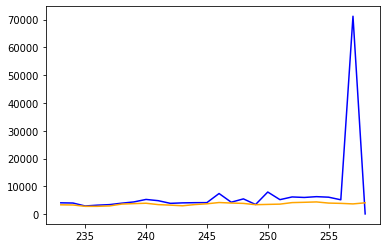

In [34]:
# Check quality of predictions
plt.plot(ga_test['new_cases'], 'blue')
plt.plot(ga_pred, 'orange')

ga_test_rmse = round(np.sqrt(sum((ga_test['new_cases']-ga_pred)**2)),2)
print(f'Test RMSE: {ga_test_rmse}')

**New York**

In [35]:
ny_casecount = cases['NewYork']

In [36]:
# Split the data set
ny_train = ny_casecount[:int(train_split*(len(ny_casecount)))]
ny_test = ny_casecount[int(train_split*(len(ny_casecount))):]

In [37]:
p_ny, d_ny, q_ny = find_best_param(ny_train, p_list, d_list, q_list)
print(p_ny, d_ny, q_ny)

3 0 5


In [38]:
ny_model = ARIMA(ny_train['new_cases'], order=(p_ny, d_ny, q_ny))

In [39]:
ny_fit = ny_model.fit()

Train RMSE: 36116.97


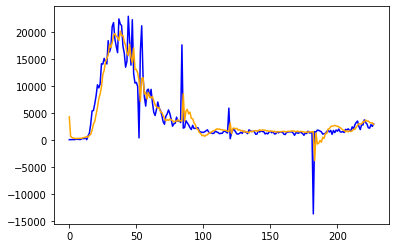

In [40]:
# Check fit on training data
plt.plot(ny_train['new_cases'], 'blue')
plt.plot(ny_fit.fittedvalues, 'orange')

ny_train_rmse = round(np.sqrt(sum((ny_train['new_cases']-ny_fit.fittedvalues)**2)),2)
print(f'Train RMSE: {ny_train_rmse}')

In [41]:
# Predict future cases
ny_pred = ny_fit.predict(start=int(train_split*(len(ny_casecount))), end=len(ny_casecount)-1)

Test RMSE: 10309.79


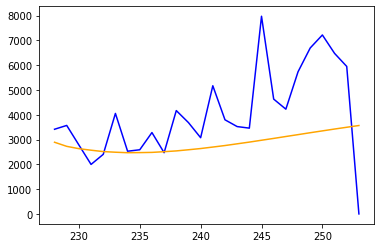

In [42]:
# Check quality of predictions
plt.plot(ny_test['new_cases'], 'blue')
plt.plot(ny_pred, 'orange')

ny_test_rmse = round(np.sqrt(sum((ny_test['new_cases']-ny_pred)**2)),2)
print(f'Test RMSE: {ny_test_rmse}')